Solving classification task for https://www.kaggle.com/prasunroy/natural-images image data set, which contains approximately 7k images in 8 categories.
Here I try to employ pre-trained Efficient net model to improve the result compared to simple deep conv NN.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [3]:
import efficientnet.keras as efn 

In [4]:
import PIL

In [5]:
data_dir = r'D:\Desktop\Python projects\Natural images dataset and projects\natural_images'

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE=(128,128)
IMAGE_SHAPE=(128,128,3)
train_datagen = ImageDataGenerator(preprocessing_function=None,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   validation_split=0.20, # set validation split
                                   rescale = (1.0/255.0))
                                   
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size = IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size = IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle= False,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation') # set as validation data

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


In [7]:
inputs = Input(shape=(128,128,3), name = "inputs")

pretrained_model = efn.EfficientNetB0(weights='imagenet')(inputs)  # or weights='noisy-student'

dropout = Dropout(rate=0.5)(pretrained_model)

outputs = Dense(8, activation='softmax', name = "outputs")(dropout)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
model = Model(inputs = inputs, outputs = outputs)

In [9]:
optimizer = optimizers.Adadelta()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 128, 128, 3)       0         
_________________________________________________________________
efficientnet-b0 (Model)      (None, 1000)              5330564   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
outputs (Dense)              (None, 8)                 8008      
Total params: 5,338,572
Trainable params: 5,296,556
Non-trainable params: 42,016
_________________________________________________________________


In [14]:
epochs = 30

model_history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=epochs, verbose=1, 
                    callbacks=None, validation_data=validation_generator, 
                    validation_steps=len(validation_generator), 
                    class_weight=None, max_queue_size=10, workers=1, 
                    use_multiprocessing=False, shuffle=True, initial_epoch=0)

Epoch 1/2
173/173 [==============================] - 423s 2s/step - loss: 1.0993 - acc: 0.5644 - val_loss: 0.4871 - val_acc: 0.9775
Epoch 2/2
173/173 [==============================] - 428s 2s/step - loss: 1.1244 - acc: 0.5526 - val_loss: 0.4325 - val_acc: 0.9898


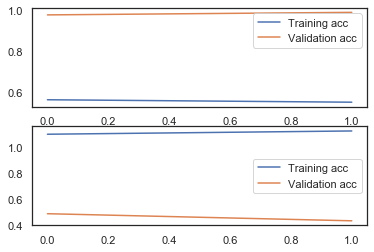

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(model_history.history['acc'], label = 'Training acc')
ax[0].plot(model_history.history['val_acc'], label = 'Validation acc')
ax[0].legend(loc = 'best')

ax[1].plot(model_history.history['loss'], label = 'Training acc')
ax[1].plot(model_history.history['val_loss'], label = 'Validation acc')
ax[1].legend(loc = 'best')